In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.4.0
GPU detected: []


## Load and Explore the NER Dataset


In [2]:
data = pd.read_csv("../data/processed_data/gmb-1.0.0.csv")
data = data.fillna(method="ffill")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Ethiopia,NNP,I-ORG
1,Sentence: 1,has,VBZ,O
2,Sentence: 1,reported,VBN,O
3,Sentence: 1,18,CD,O
4,Sentence: 1,new,JJ,O


In [3]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(data["Tag"].values))
num_tags = len(tags)


## Retrieve sentences with tags


In [4]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [5]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [6]:
sentences[0]

[('Ethiopia', 'NNP', 'I-ORG'),
 ('has', 'VBZ', 'O'),
 ('reported', 'VBN', 'O'),
 ('18', 'CD', 'O'),
 ('new', 'JJ', 'O'),
 ('cases', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('polio', 'NN', 'O'),
 ('as', 'IN', 'O'),
 ('it', 'PRP', 'O'),
 ('begins', 'VBZ', 'O'),
 ('a', 'DT', 'O'),
 ('nationwide', 'JJ', 'O'),
 ('vaccination', 'NN', 'O'),
 ('program', 'NN', 'O'),
 ('targeting', 'VBG', 'O'),
 ('more', 'JJR', 'O'),
 ('than', 'IN', 'O'),
 ('16', 'CD', 'O'),
 ('million', 'CD', 'O'),
 ('children', 'NNS', 'O'),
 ('under', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('age', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('five', 'CD', 'O'),
 ('.', '.', 'O')]

### Mappings between words and Tags

In [7]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [8]:
word2idx

{'depart': 1,
 'responsible': 2,
 '8,599': 3,
 'N': 4,
 'influences': 5,
 'mid-year': 6,
 '106': 7,
 'hip-hop': 8,
 'removed': 9,
 'increasing': 10,
 'Nawab': 11,
 'warmest': 12,
 'Biennial': 13,
 'Bududa': 14,
 'Doctor': 15,
 'Previously': 16,
 'Ram': 17,
 'uprising': 18,
 'participating': 19,
 'which': 20,
 'territory': 21,
 'nuclear': 22,
 'futures': 23,
 '77-year-old': 24,
 '1990s': 25,
 '25': 26,
 'Osthoff': 27,
 'filed': 28,
 'significant': 29,
 'individuals': 30,
 'awarded': 31,
 'Andrus': 32,
 'bit': 33,
 'Ramaldi': 34,
 'spite': 35,
 '76': 36,
 'proximity': 37,
 'reconciliation': 38,
 'Janet': 39,
 '88,000': 40,
 'herself': 41,
 'millions': 42,
 'peak': 43,
 'M.': 44,
 'boarded': 45,
 'lawmakers': 46,
 'arrangement': 47,
 'consult': 48,
 'sympathizers': 49,
 'Colombian': 50,
 'warlords': 51,
 'Cambodia': 52,
 'Rahman': 53,
 'improvised': 54,
 'Poll': 55,
 'productivity': 56,
 'missions': 57,
 'Nel': 58,
 'moderate': 59,
 'medications': 60,
 'lobbying': 61,
 '1964': 62,
 'Award

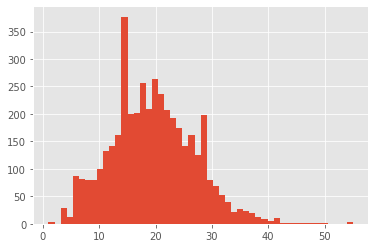

In [9]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

# 50 tokens should be fine!!!

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])

In [16]:
len([[word2idx[w[0]] for w in s] for s in sentences][0])
X[0]

array([ 5501, 10175,  6541,   974,  6243,   437,  6600,  3066,  7239,
        6441,   961,  5611,  1298,   857,  1000,  9661,  1348,  2263,
        8863,  7692,   754,  9814,  5467,  8833,  6600,  8196,  3860,
       10325, 10325, 10325, 10325, 10325, 10325, 10325, 10325, 10325,
       10325, 10325, 10325, 10325, 10325, 10325, 10325, 10325, 10325,
       10325, 10325, 10325, 10325, 10325], dtype=int32)

In [40]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [41]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [42]:
input_word = Input(shape=(maxlen,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=maxlen)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            516300    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 10)            2010      
Total params: 639,110
Trainable params: 639,110
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from livelossplot.tf_keras import PlotLossesCallback
from livelossplot.inputs.tf_keras import PlotLossesCallback


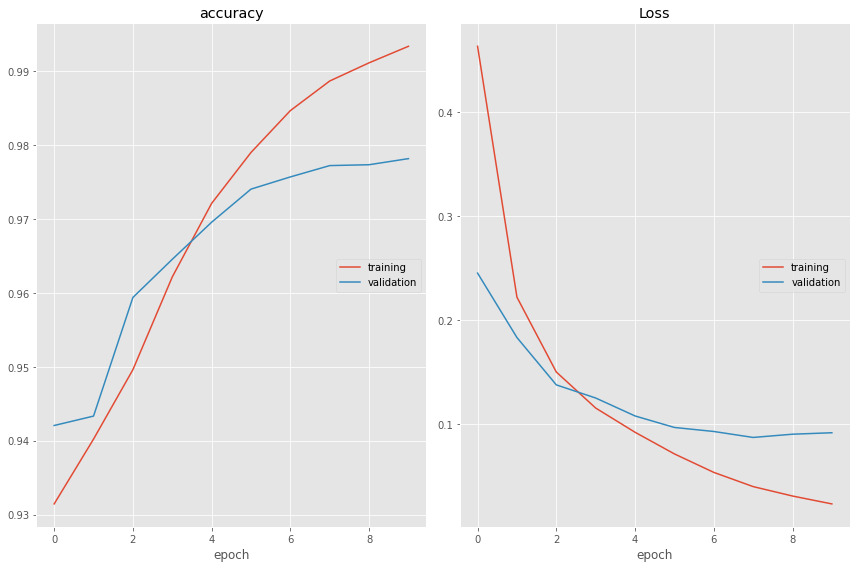

accuracy
	training         	 (min:    0.931, max:    0.993, cur:    0.993)
	validation       	 (min:    0.942, max:    0.978, cur:    0.978)
Loss
	training         	 (min:    0.023, max:    0.463, cur:    0.023)
	validation       	 (min:    0.087, max:    0.245, cur:    0.091)

Epoch 00010: val_loss did not improve from 0.08690
CPU times: user 4min 29s, sys: 1min 13s, total: 5min 42s
Wall time: 1min 8s


In [45]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

In [46]:
model.evaluate(x_test, y_test)

27/27 [==============================] - 0s 9ms/step - loss: 0.0914 - accuracy: 0.9782


[0.09142276644706726, 0.9781839847564697]

In [57]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
medieval       O	O
15-nation      O	O
headlining     O	O
heavy          O	O
consolidation  I-DAT	I-DAT
Abdal          O	O
dietary        O	O
heavy          O	O
under          I-DAT	I-DAT
130,000        O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD       

In [54]:
words[-1]

'ENDPAD'

In [55]:
x_test[0]

array([ 4097, 10080,  6923,  2675,  8925,  3045,  7146,  7483,  6024,
        6923,  2675,  5907,  7851,   225,  9744,  1276, 10137,  7226,
       10193,  3386, 10325, 10325, 10325, 10325, 10325, 10325, 10325,
       10325, 10325, 10325, 10325, 10325, 10325, 10325, 10325, 10325,
       10325, 10325, 10325, 10325, 10325, 10325, 10325, 10325, 10325,
       10325, 10325, 10325, 10325, 10325], dtype=int32)

In [56]:
words[10325]

'ENDPAD'